In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, balanced_accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
import sys

file_path = "https://raw.githubusercontent.com/FarzinSohraby/PathInHydro/refs/heads/main/"
pd.options.display.precision = 2

%matplotlib inline

In [ ]:
# Load and preprocess the main data set (Df-H2ase-CO)
data = pd.read_csv(file_path+'Df_H2ase_CO_H2.csv')
# Add a 'Molecule' column based on the 'Trajectory' column to distinguish between CO and H2
data['Molecule'] = data['Trajectory'].apply(lambda x: 'H2' if 'H2' in x else 'CO')

data = data.drop(["Trajectory", "Frame", "Binary"], axis=1)

X = data.drop(['Pathway-new', "Molecule"], axis=1)  # Features
y = data['Pathway-new']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=data['Molecule'])
X_train.shape, X_test.shape

((629, 804), (270, 804))

In [ ]:
# Calculate distribution percentages for the entire dataset
total_distribution = data['Molecule'].value_counts(normalize=True) * 100
print("Overall Distribution (%):\n", total_distribution)

# Calculate distribution in each set based on indices
train_distribution = data.loc[X_train.index, 'Molecule'].value_counts(normalize=True) * 100
test_distribution = data.loc[X_test.index, 'Molecule'].value_counts(normalize=True) * 100

print("\nTraining Set Distribution (%):\n", train_distribution)
print("\nTest Set Distribution (%):\n", test_distribution)


Overall Distribution (%):
 Molecule
CO    91.769
H2     8.231
Name: proportion, dtype: float64

Training Set Distribution (%):
 Molecule
CO    91.733
H2     8.267
Name: proportion, dtype: float64

Test Set Distribution (%):
 Molecule
CO    91.852
H2     8.148
Name: proportion, dtype: float64


In [ ]:
data = pd.read_csv(file_path+'Df_H2ase_O2.csv')
data = data.drop(["Trajectory", "Frame", "Binary"], axis=1)

X_O2 = data.drop('Pathway-new', axis=1)  # Features
y_O2 = data['Pathway-new']  # Target variable

In [ ]:
data = pd.read_csv(file_path+'Mdg_H2ase_CO.csv')
data = data.drop(["Trajectory", "Frame", "Binary"], axis=1)

X_Mdg_CO = data.drop('Pathway-new', axis=1)  # Features
y_Mdg_CO = data['Pathway-new']  # Target variable

In [ ]:
data = pd.read_csv(file_path+'Mdg_H2ase_H2.csv')
data = data.drop(["Trajectory", "Frame", "Binary"], axis=1)

X_Mdg_H2 = data.drop('Pathway-new', axis=1)  # Features
y_Mdg_H2 = data['Pathway-new']  # Target variable

In [ ]:
data = pd.read_csv(file_path+'Mdg_H2ase_O2.csv')
data = data.drop(["Trajectory", "Frame", "Binary"], axis=1)

X_Mdg_O2 = data.drop('Pathway-new', axis=1)  # Features
y_Mdg_O2 = data['Pathway-new']  # Target variable

In [ ]:
oversampler = RandomOverSampler(random_state=1)

X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [ ]:
def calc_metrics(y, y_pred):
    acc = accuracy_score(y, y_pred)
    ba = balanced_accuracy_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    return(acc, ba, mcc, cm)

def natural_sort_key(label):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', label)]

def plot_heatmap(cm, classes, title, ax=None, adjust_yticks=False):
    if not ax:
        _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

    # Sort classes naturally
    sorted_classes = sorted(classes, key=natural_sort_key)

    # Reorder the confusion matrix based on the sorted class order
    indices = [classes.index(cls) for cls in sorted_classes]
    cm = cm[np.ix_(indices, indices)]

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, ax=ax,
                xticklabels=sorted_classes, yticklabels=sorted_classes,
                annot_kws={"fontsize": 11, "fontweight": "bold"})
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Observed', fontsize=12)
    if adjust_yticks:
        ax.tick_params(axis='y', rotation=0)
    ax.set_title(title, fontsize=14)

In [ ]:
rfc_mdl = RandomForestClassifier(n_estimators=500, max_depth=30, ccp_alpha=0.001,
                                 max_samples=0.9, oob_score=True,
                                 random_state=1).fit(X_train_resampled, y_train_resampled)

In [ ]:
# calculate and display the results
ds_names = ["Df-H$_2$ase-CO/Df-H$_2$ase-H$_2$\nTraining Set", "Df-H$_2$ase-CO/Df-H$_2$ase-H$_2$\nTest ", "Df-H$_2$ase-O$_2$-test", "Mdg-H$_2$ase-CO-test", "Mdg-H$_2$ase-H$_2$-test", "Mdg-H$_2$ase-O$_2$-test"]
ds_names_formatted = ['Training Set', 'Df-H$_2$ase-CO/Df-H$_2$ase-H$_2$\nTest Set', 'Df-H$_2$ase-O$_2$ Test Set','Mdg-H$_2$ase-CO Test Set','Mdg-H$_2$ase-H$_2$ Test Set','Mdg-H$_2$ase-O$_2$ Test Set']
ds_names_table = ['Df-H2ase-CO/Df-H2ase-H2 Training Set', 'Df-H2ase-CO/Df-H2ase-H2 Test Set', 'Df-H2ase-O2 Test Set','Mdg-H2ase-CO Test Set','Mdg-H2ase-H2 Test Set','Mdg-H2ase-O2 Test Set']
ds_features = [X_train, X_test, X_O2, X_Mdg_CO, X_Mdg_H2, X_Mdg_O2]
ds_target = [y_train, y_test, y_O2, y_Mdg_CO, y_Mdg_H2, y_Mdg_O2]

results_dict = {}

for i in range(len(ds_names)):
    y_pred = rfc_mdl.predict(ds_features[i])
    acc, ba, mcc, cm = calc_metrics(ds_target[i], y_pred)
    results_dict[ds_names_table[i]] = [y_pred, acc, ba, mcc, cm]

results_df = pd.DataFrame.from_dict(results_dict, orient="index",
                                    columns=["predictions", "accuracy", "BA", "MCC", "CM"])

display(results_df.loc[:,["accuracy", "BA", "MCC"]])

del y_pred, acc, ba, mcc, cm

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,accuracy,BA,MCC
Df-H2ase-CO/Df-H2ase-H2 Training Set,0.97,0.99,0.96
Df-H2ase-CO/Df-H2ase-H2 Test Set,0.81,0.61,0.74
Df-H2ase-O2 Test Set,0.68,0.73,0.47
Mdg-H2ase-CO Test Set,0.87,0.69,0.75
Mdg-H2ase-H2 Test Set,0.45,0.54,0.38
Mdg-H2ase-O2 Test Set,0.53,0.42,0.26


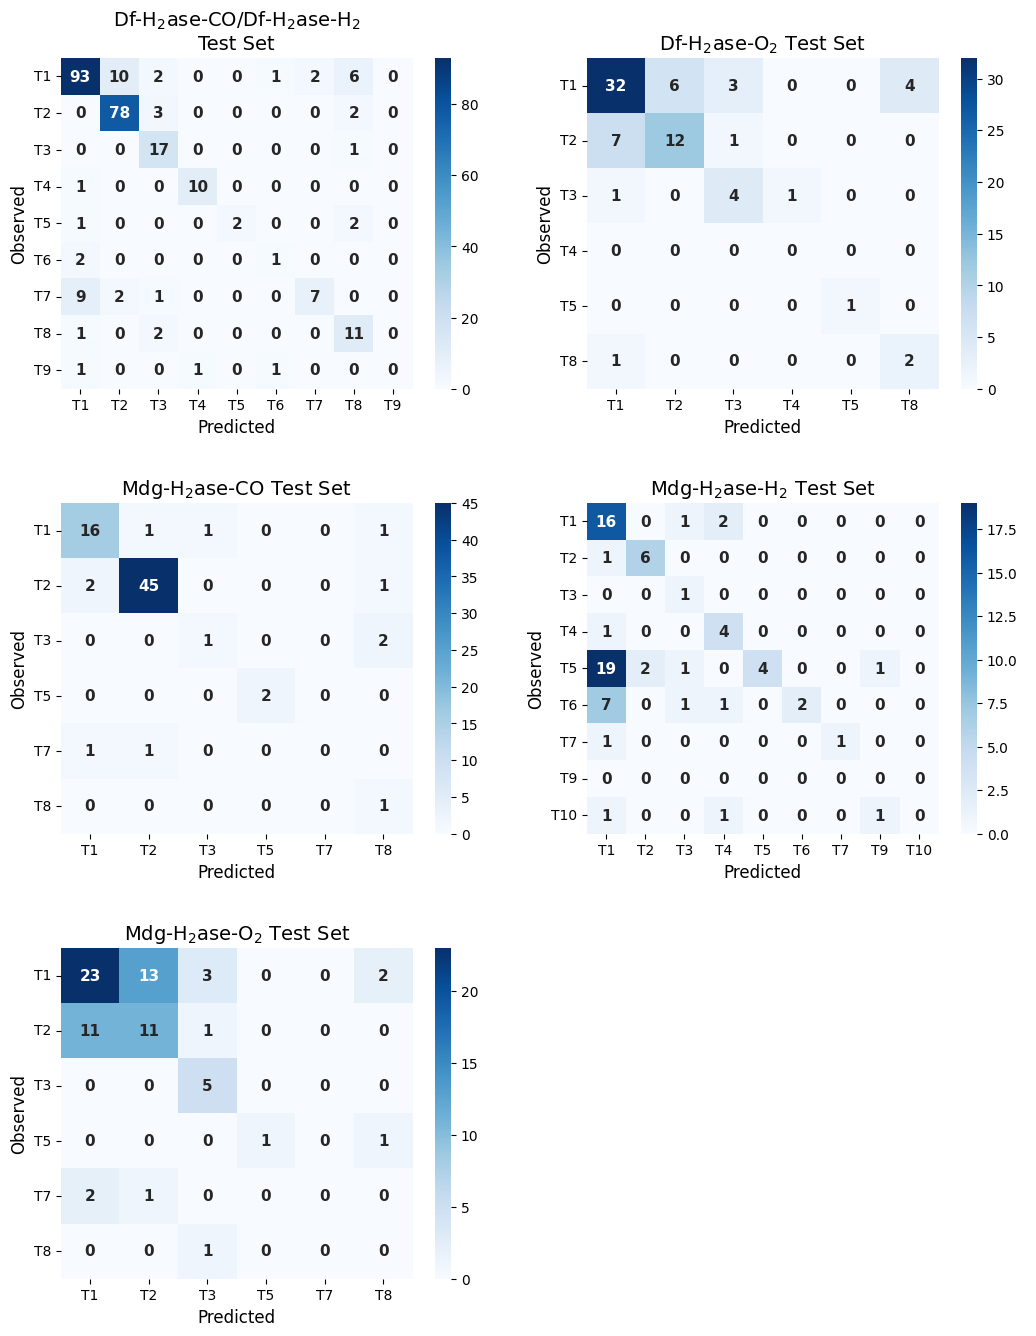

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11, 14))
k = 0

for i, j in np.ndindex(axes.shape):
    if k == 5:
        axes[i, j].axis('off')
        continue

    if k == 4:
        ax = axes[2, 0]
    else:
        ax = axes[i, j]

    all_labels = sorted(set(list(results_df.iloc[k+1, 0]) + list(ds_target[k+1])))
    plot_heatmap(results_df.iloc[k+1, -1], all_labels, ds_names_formatted[k+1],
                 ax, adjust_yticks=True)

    k += 1

axes[2, 1].axis('off')

fig.tight_layout(pad=3)
#plt.savefig(file_path + 'CM-Multiclass.jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Instantiate the DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=1)

# Fit the model on the resampled training data
dummy_clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred_dummy = dummy_clf.predict(X_test)

# Assess accuracy on the test set
balanced_accuracy_test_dummy = balanced_accuracy_score(y_test, y_pred_dummy)
mcc_test_dummy = matthews_corrcoef(y_test, y_pred_dummy)

print(f'Baseline (Dummy Classifier) Balanced Accuracy on the test set: {balanced_accuracy_test_dummy:.2f}')
print(f'Baseline (Dummy Classifier) Matthews Correlation Coefficient on the test set: {mcc_test_dummy:.2f}')

# Predict on the training set
y_pred_train_dummy = dummy_clf.predict(X_train)

# Assess accuracy on the training set
balanced_accuracy_train_dummy = balanced_accuracy_score(y_train, y_pred_train_dummy)
mcc_train_dummy = matthews_corrcoef(y_train, y_pred_train_dummy)

print(f'Baseline (Dummy Classifier) Balanced Accuracy on the training set: {balanced_accuracy_train_dummy:.2f}')
print(f'Baseline (Dummy Classifier) Matthews Correlation Coefficient on the training set: {mcc_train_dummy:.2f}')

Baseline (Dummy Classifier) Balanced Accuracy on the test set: 0.11
Baseline (Dummy Classifier) Matthews Correlation Coefficient on the test set: 0.00
Baseline (Dummy Classifier) Balanced Accuracy on the training set: 0.11
Baseline (Dummy Classifier) Matthews Correlation Coefficient on the training set: 0.00


In [ ]:
y_train_scrambled = shuffle(y_train, random_state=1)
X_train_scram_resampled, y_train_scram_resampled = oversampler.fit_resample(X_train, y_train_scrambled)

rfc_scram = RandomForestClassifier(n_estimators=500, max_depth=30, ccp_alpha=0.001,
                                   max_samples=0.9, oob_score=True,
                                   random_state=1)
rfc_scram.fit(X_train_scram_resampled, y_train_scram_resampled)

# Predict on the training set with scrambled labels
y_pred_train_scrambled = rfc_scram.predict(X_train)
y_scram_pred_test = rfc_scram.predict(X_test)

# Assess accuracy on the training set with scrambled labels
balanced_accuracy_train_scrambled = balanced_accuracy_score(y_train_scrambled, y_pred_train_scrambled)
mcc_train_scrambled = matthews_corrcoef(y_train_scrambled, y_pred_train_scrambled)
balanced_accuracy_test_scrambled = balanced_accuracy_score(y_test, y_scram_pred_test)
mcc_test_scrambled = matthews_corrcoef(y_test, y_scram_pred_test)

print(f'Scrambled Balanced Accuracy on the training set: {balanced_accuracy_train_scrambled:.2f}')
print(f'Scrambled Matthews Correlation Coefficient on the training set: {mcc_train_scrambled:.2f}')
print(f'Scrambled Balanced Accuracy on the test set: {balanced_accuracy_test_scrambled:.2f}')
print(f'Scrambled Matthews Correlation Coefficient on the test set: {mcc_test_scrambled:.2f}')

### Convert the Multiclass Predictions to Binary Labels

- Evaluate the binary separation effectiveness of the multiclass model.

In [ ]:
# convert the multiclass predictions to binary labels
# calculate the binary prediction metrics
ds_target_binary = []
results_dict_binary = {}
for i in range(6):
    binlbl = ["Primary" if lbl in ["T1", "T2", "T7"] else "Secondary" for lbl in ds_target[i]]
    binpred = ["Primary" if lbl in ["T1", "T2", "T7"] else "Secondary" for lbl in results_df.iloc[i,0]]
    acc, ba, mcc, cm = calc_metrics(binlbl, binpred)
    results_dict_binary[ds_names_table[i]] = [binpred, acc, ba, mcc, cm]
    ds_target_binary.append(binlbl)

results_df_binary = pd.DataFrame.from_dict(results_dict_binary, orient="index",
                                 columns=["predictions", "accuracy", "BA", "MCC", "CM"])

display(results_df_binary.loc[:,["accuracy", "BA", "MCC"]])

del binlbl, binpred, acc, ba, mcc, cm

,accuracy,BA,MCC
Df-H2ase-CO/Df-H2ase-H2 Training Set,0.98,0.99,0.96
Df-H2ase-CO/Df-H2ase-H2 Test Set,0.92,0.91,0.77
Df-H2ase-O2 Test Set,0.87,0.84,0.56
Mdg-H2ase-CO Test Set,0.96,0.98,0.80
Mdg-H2ase-H2 Test Set,0.56,0.63,0.28
Mdg-H2ase-O2 Test Set,0.92,0.96,0.72


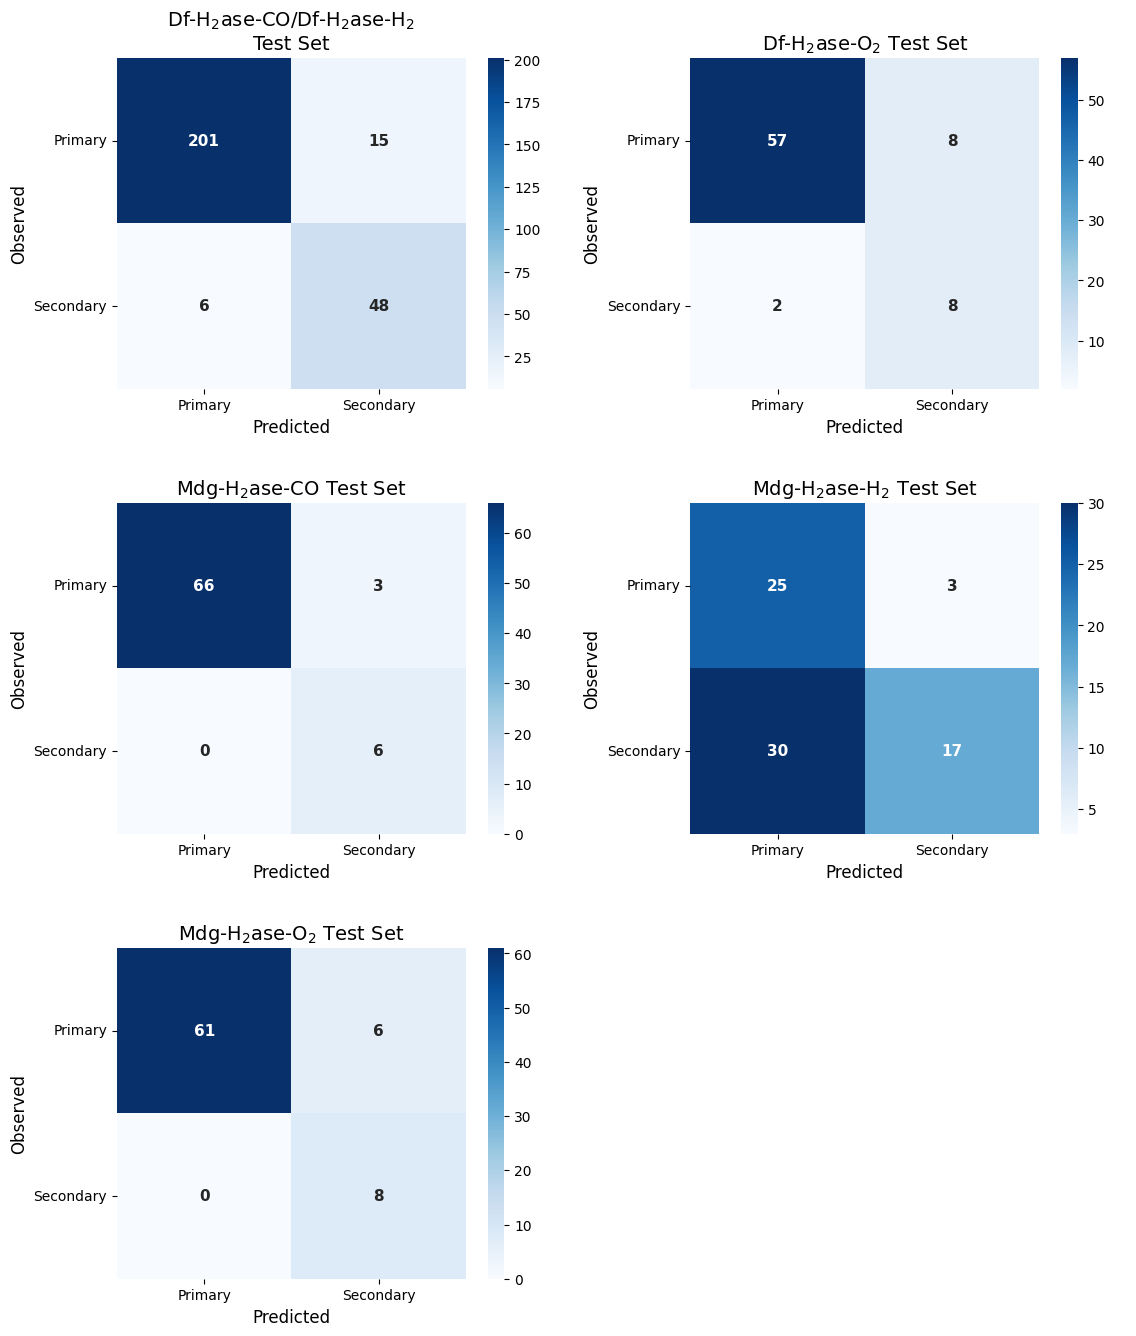

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))
k = 0

for i, j in np.ndindex(axes.shape):
    if k == 5:
        axes[i, j].axis('off')
        continue

    if k == 4:
        ax = axes[2, 0]
    else:
        ax = axes[i, j]

    all_labels = sorted(set(list(results_df_binary.iloc[k+1, 0]) + list(ds_target_binary[k+1])))
    plot_heatmap(results_df_binary.iloc[k+1, -1], all_labels, ds_names_formatted[k+1],
                 ax, adjust_yticks=True)

    k += 1

axes[2, 1].axis('off')

fig.tight_layout(pad=3)
#plt.savefig(file_path + 'Multi-Binary-Predict-CM.jpg', dpi=300, format='jpg')
plt.show()


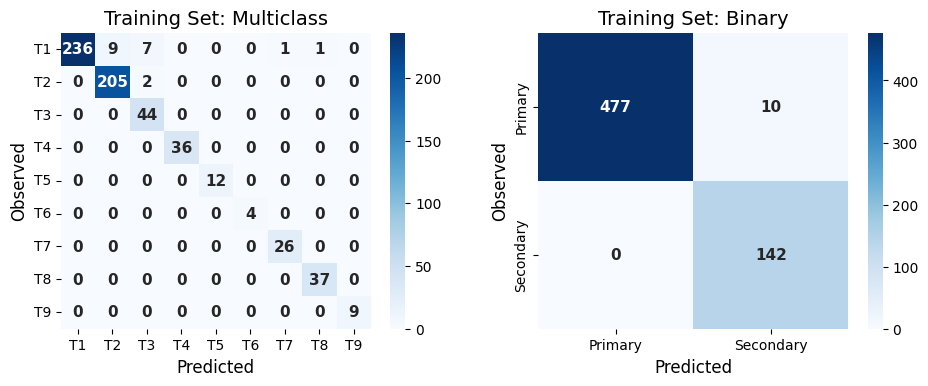

In [ ]:
mc_labels = sorted(set(list(results_df.iloc[0,0]) + list(ds_target[0])))
bin_labels = ["Primary", "Secondary"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
plot_heatmap(results_df.iloc[0,-1], mc_labels, "Training Set: Multiclass",
             axes[0], adjust_yticks=True)
plot_heatmap(results_df_binary.iloc[0,-1], bin_labels, "Training Set: Binary",
             axes[1])
plt.tight_layout(pad=3)
#plt.savefig(file_path + 'Multi-Binary-Training.jpg', dpi=300, format='jpg')
plt.show()

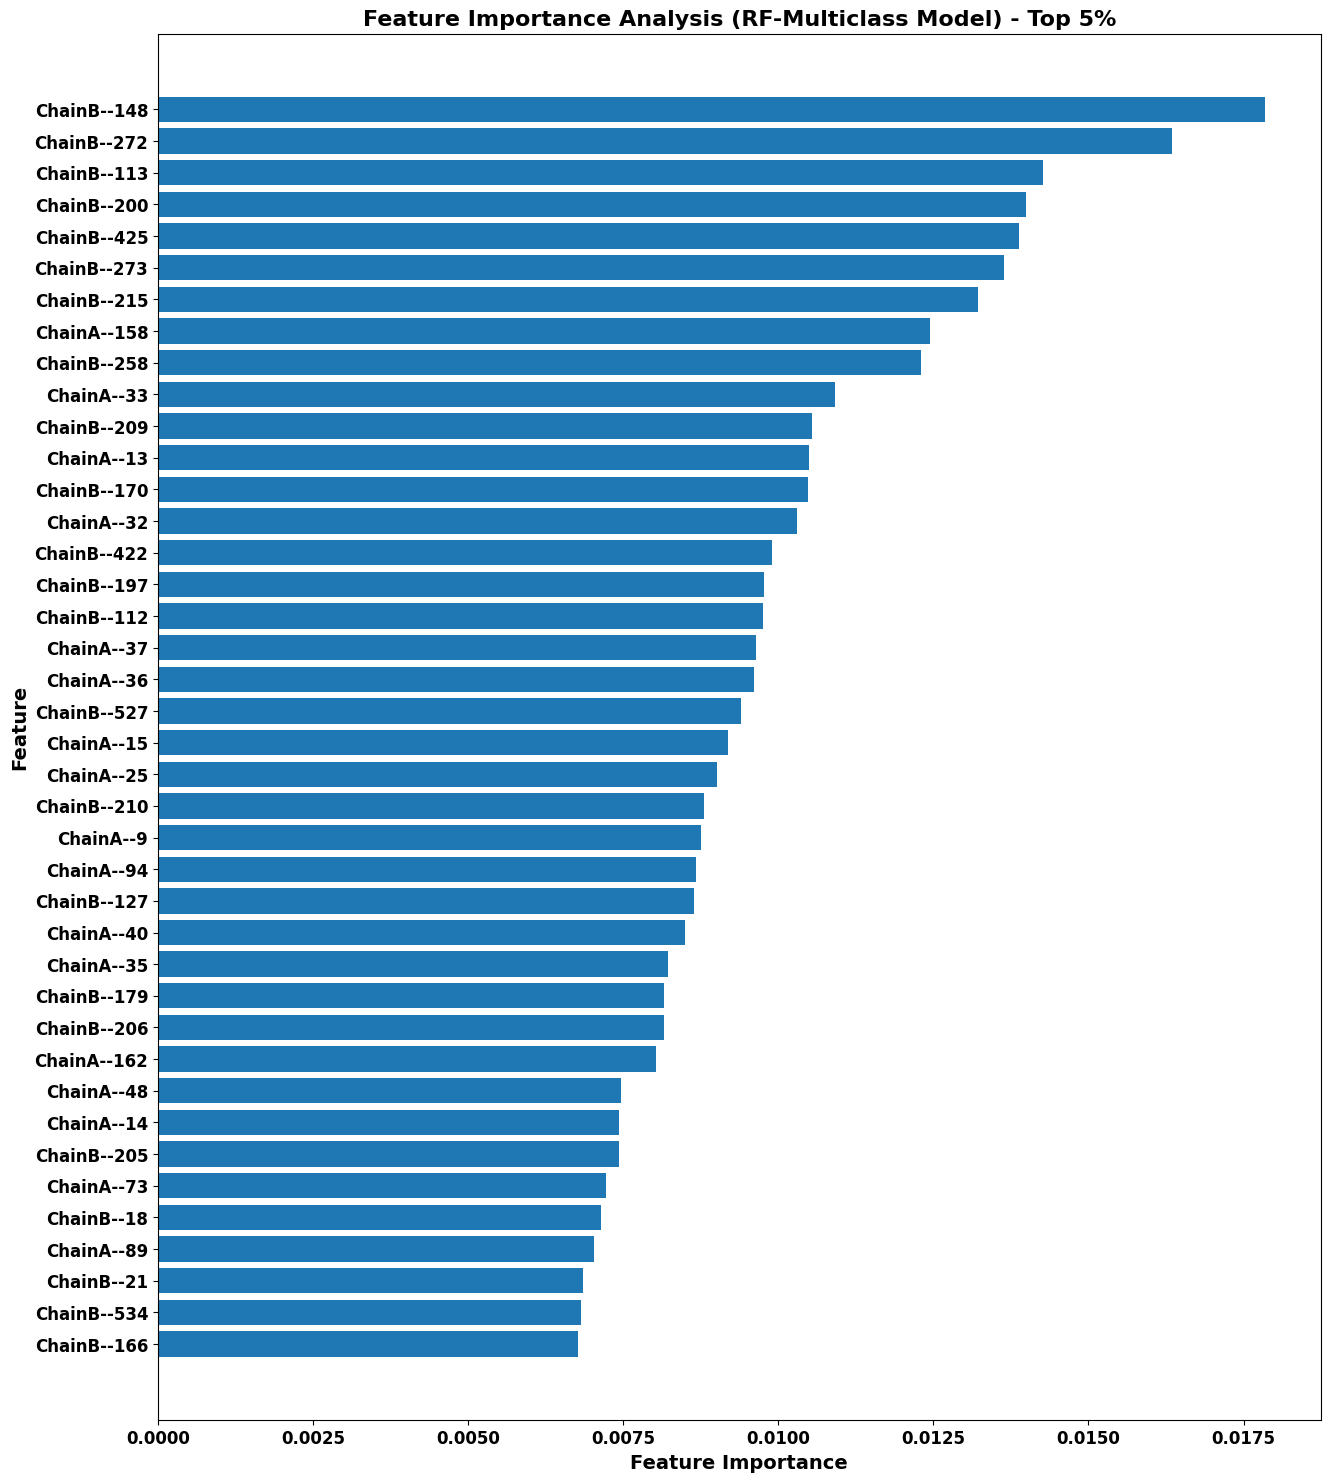

In [ ]:
feature_importances = rfc_mdl.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Calculate the number of features to keep (top 5%)
num_top_features = int(len(feature_importance_df) * 0.05)
top_feature_importance_df = feature_importance_df.head(num_top_features)

plt.figure(figsize=(15, 18))
plt.barh(top_feature_importance_df['Feature'], top_feature_importance_df['Importance'])
plt.xlabel('Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Feature', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('Feature Importance Analysis (RF-Multiclass Model) - Top 5%', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
#plt.savefig(file_path+'Feature-Importance-multi.jpg', dpi=300, format='jpg')
plt.show()